# NLP_applied_in_Insurance: Text_Analysis

# Upload Libraries

In [2]:
!pip install langdetect

     |████████████████████████████████| 981 kB 884 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=efd5596a0f265313b9b1499468ef2ea0c9a40396c6833b97b0c14688c9be6402
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [3]:
from numpy.random import seed
seed(1)
import tensorflow.keras
tensorflow.random.set_seed(2)
import os
os.environ['PYTHONHASHSEED'] = str(0)
TF_DETERMINISTIC_OPS=1

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from sklearn.metrics import confusion_matrix
import re
import string
import nltk
from nltk.tokenize import word_tokenize
import gensim
from nltk.corpus import stopwords
from gensim.models import Word2Vec 
from gensim.parsing.preprocessing import remove_stopwords
import gensim.downloader as gensim_api
import langdetect 
import spacy
from spacy import displacy
import collections
from collections import Counter
import en_core_web_sm
from sklearn import feature_extraction, manifold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
#from sklearn.decomposition import PCA
#from sklearn.cluster import KMeans

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Requirements

In [4]:
print(np.__version__)

1.19.5


In [5]:
print(pd.__version__)

1.3.4


In [6]:
print(sklearn.__version__)

0.23.2


In [7]:
print(sns.__version__)

0.11.2


In [8]:
print(tensorflow.keras.__version__)

2.6.0


# Upload data set

In [9]:
# Reading File
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

### Language detection

In [10]:
txt = df_train["text"].iloc[0]
print(txt, " --> ", langdetect.detect(txt))

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all  -->  en


In [11]:
df_train['lang'] = df_train["text"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "")
df_train.head()

,id,keyword,location,text,target,lang
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,en
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,en
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,en
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,en
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,en


In [12]:
df = df_train[df_train["lang"]=="en"]

# Text Preprocessing

In [13]:
nlp = spacy.load("en_core_web_sm")
def lemmatizer(text):        
    lem = []
    doc = nlp(text)
    for word in doc:
        lem.append(word.lemma_)
    return " ".join(lem)

In [14]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = remove_stopwords(text)
    text = lemmatizer(text)
    return text

In [15]:
i=3
df_cleaned = pd.DataFrame(df.apply(lambda x: clean_text(x.iloc[i]), axis=1), columns = ['text_cleaned'])
df_new = pd.concat([df,df_cleaned], axis=1)

In [16]:
df_new.head()

,id,keyword,location,text,target,lang,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,en,deed reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,en,forest near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,en,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,en,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,en,got send photo ruby alaska smoke wildfire pour...


# Named Entity Recognition

In [17]:
# model
ner = en_core_web_sm.load()


In [18]:
# tag text cleaned
txt = df_new["text_cleaned"].iloc[5]
doc_cleaned = ner(txt)
# display result
spacy.displacy.render(doc_cleaned, style="ent")

In [19]:
print([(X.text, X.label_) for X in doc_cleaned.ents])

[('california', 'GPE'), ('lake county', 'GPE')]


In [20]:
labels = [x.label_ for x in doc_cleaned.ents]
Counter(labels)

Counter({'GPE': 2})

In [22]:
# tag text
txt = df_new["text"].iloc[5]
doc = ner(txt)
# display result
spacy.displacy.render(doc, style="ent")

In [23]:
print([(X.text, X.label_) for X in doc.ents])

[('#RockyFire Update', 'ORG'), ('California Hwy', 'PERSON'), ('20', 'CARDINAL'), ('Lake County', 'GPE')]


In [25]:
labels = [x.label_ for x in doc.ents]
Counter(labels)

Counter({'ORG': 1, 'PERSON': 1, 'CARDINAL': 1, 'GPE': 1})

# N-grams

In [26]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_new['text_cleaned'], 20)
df1 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

In [27]:
df1

,unigram,count
0,nt,372
1,like,368
2,amp,292
3,new,229
4,people,198
5,news,191
6,burn,173
7,kill,163
8,crash,162
9,video,161


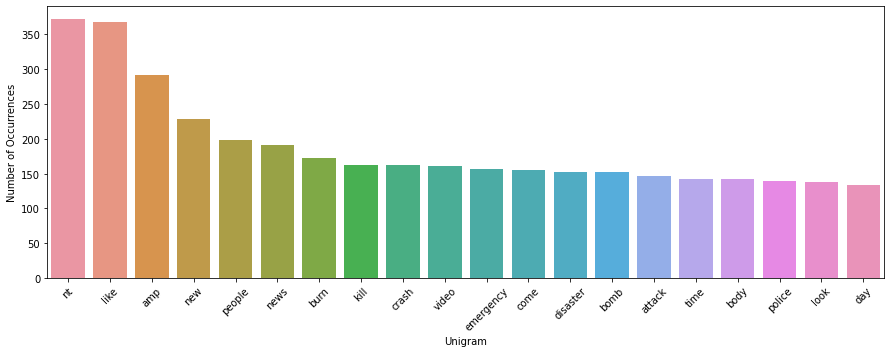

In [28]:
plt.figure(figsize=(15,5))
sns.barplot(x=df1['unigram'], y=df1['count'])
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xlabel('Unigram', fontsize=10)
plt.xticks(rotation=45)
plt.show()

In [29]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_new['text_cleaned'], 20)
df2 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

In [30]:
df2

,bigram,count
0,body bag,62
1,burn building,58
2,look like,50
3,suicide bomber,45
4,northern california,41
5,gon na,40
6,youtube video,40
7,like youtube,39
8,cross body,39
9,oil spill,39


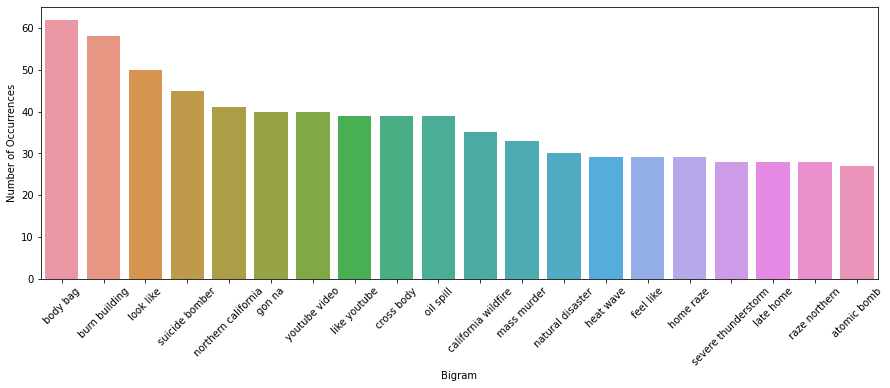

In [31]:
plt.figure(figsize=(15,5))
sns.barplot(x=df2['bigram'], y=df2['count'])
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xlabel('Bigram', fontsize=10)
plt.xticks(rotation=45)
plt.show()

In [32]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_new['text_cleaned'], 20)
df3 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

In [33]:
df3

,trigram,count
0,like youtube video,39
1,northern california wildfire,29
2,late home raze,28
3,home raze northern,28
4,raze northern california,27
5,family sue legionnaire,26
6,family affect fatal,26
7,affect fatal outbreak,26
8,obama declare disaster,25
9,declare disaster typhoondevastate,25


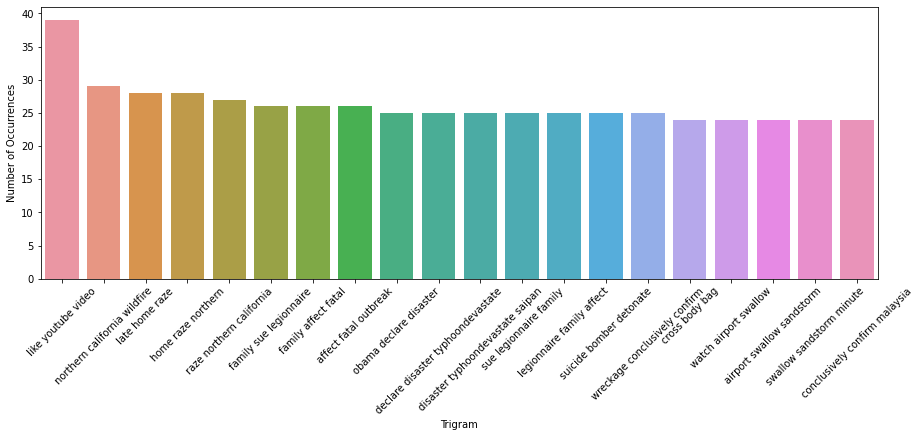

In [34]:
plt.figure(figsize=(15,5))
sns.barplot(x=df3['trigram'], y=df3['count'])
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xlabel('Trigram', fontsize=10)
plt.xticks(rotation=45)
plt.show()

In [35]:
def get_top_n_fourgram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(4, 4), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_fourgram(df_new['text_cleaned'], 20)
df4 = pd.DataFrame(common_words, columns = ['four-gram' , 'count'])

In [36]:
df4

,four-gram,count
0,late home raze northern,27
1,home raze northern california,27
2,raze northern california wildfire,27
3,family affect fatal outbreak,26
4,obama declare disaster typhoondevastate,25
5,declare disaster typhoondevastate saipan,25
6,family sue legionnaire family,25
7,sue legionnaire family affect,25
8,legionnaire family affect fatal,25
9,watch airport swallow sandstorm,24


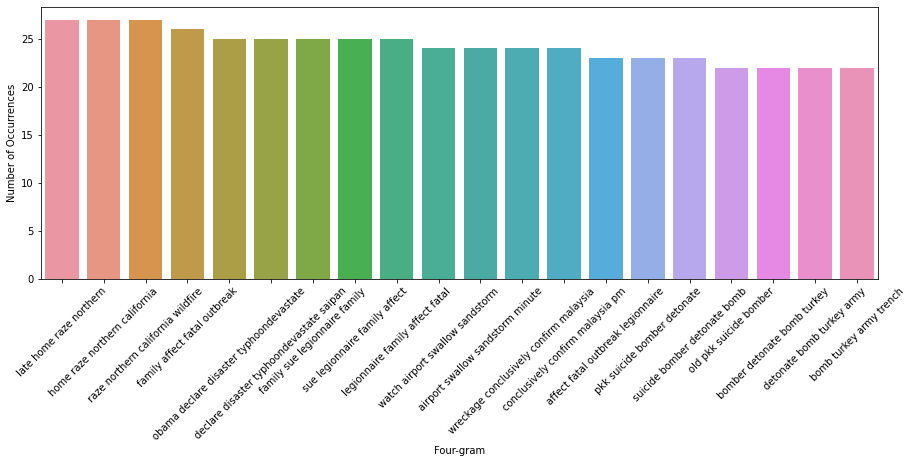

In [37]:
plt.figure(figsize=(15,5))
sns.barplot(x=df4['four-gram'], y=df4['count'])
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xlabel('Four-gram', fontsize=10)
plt.xticks(rotation=45)
plt.show()

In [38]:
def get_top_n_fivegram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(5, 5), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_fivegram(df_new['text_cleaned'], 20)
df5 = pd.DataFrame(common_words, columns = ['five-gram' , 'count'])

In [39]:
df5

,five-gram,count
0,late home raze northern california,27
1,home raze northern california wildfire,27
2,obama declare disaster typhoondevastate saipan,25
3,family sue legionnaire family affect,25
4,sue legionnaire family affect fatal,25
5,legionnaire family affect fatal outbreak,25
6,watch airport swallow sandstorm minute,24
7,wreckage conclusively confirm malaysia pm,24
8,family affect fatal outbreak legionnaire,23
9,pkk suicide bomber detonate bomb,23


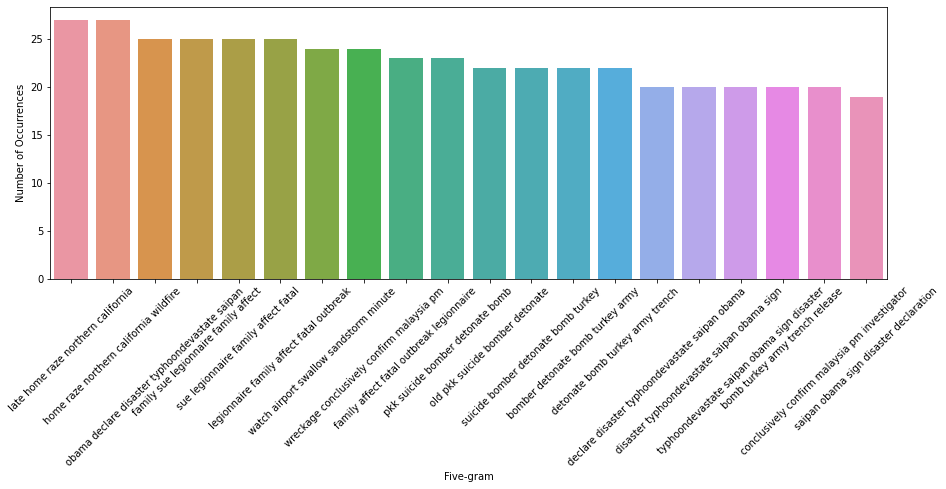

In [40]:
plt.figure(figsize=(15,5))
sns.barplot(x=df5['five-gram'], y=df5['count'])
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xlabel('Five-gram', fontsize=10)
plt.xticks(rotation=45)
plt.show()

# Bag-of-Words - Topic Modelling with Latent Dirichlet Allocation

In [41]:
# LDA plot
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(35, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights)
        ax.set_title(f'Topic {topic_idx}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [42]:
# parameters for LDA
n_topics = 3
n_top_words = 20

In [43]:
# LDA model
np.random.seed(0)
lda_model = LatentDirichletAllocation(n_components=n_topics, 
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1 
                                     )

### 1-gram

In [44]:
# Tokenization into 1-gram and vectorization 
np.random.seed(0)
# Dropped tokens that appeared in less than 2 sentences 
bow_model = CountVectorizer(analyzer='word', 
                             ngram_range=(1,1), 
                             min_df=2,                         # minimum required occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000)                # max number of unique words.                             
bow_model.fit(df_new['text_cleaned'])
bow_1g = bow_model.transform(df_new['text_cleaned'])

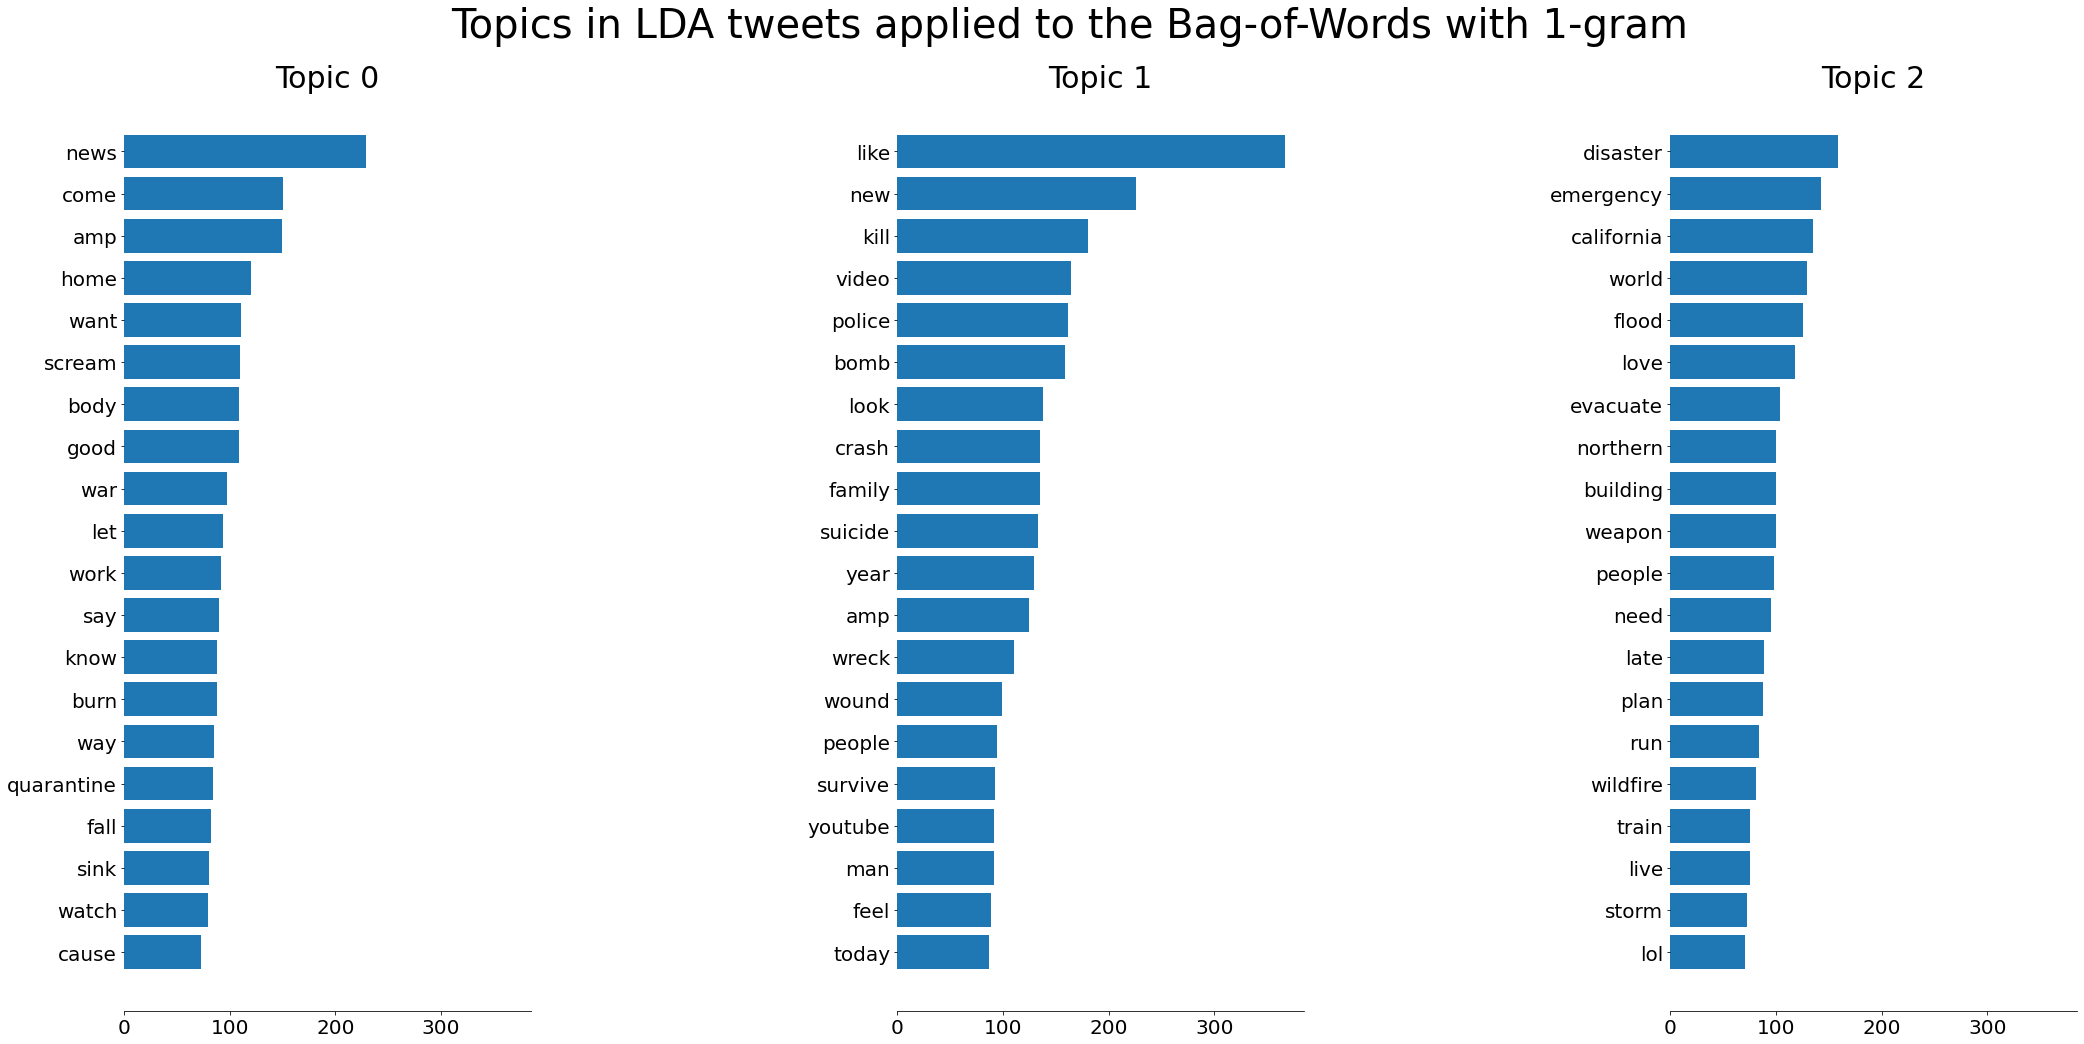

In [45]:
words_bow_1g = bow_model.get_feature_names()
lda_1g = lda_model.fit(bow_1g)
lda_topic_results_1g = lda_model.transform(bow_1g)
plot_top_words(lda_1g, words_bow_1g, n_top_words, 'Topics in LDA tweets applied to the Bag-of-Words with 1-gram')

### 2-gram

In [46]:
# Tokenization into 2-gram and vectorization 
np.random.seed(0)
# Dropped tokens that appeared in less than 2 sentences 
bow_model = CountVectorizer(analyzer='word', 
                             ngram_range=(2,2), 
                             min_df=2,                         # minimum required occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000)                # max number of unique words.                             
bow_model.fit(df_new['text_cleaned'])
bow_2g = bow_model.transform(df_new['text_cleaned'])

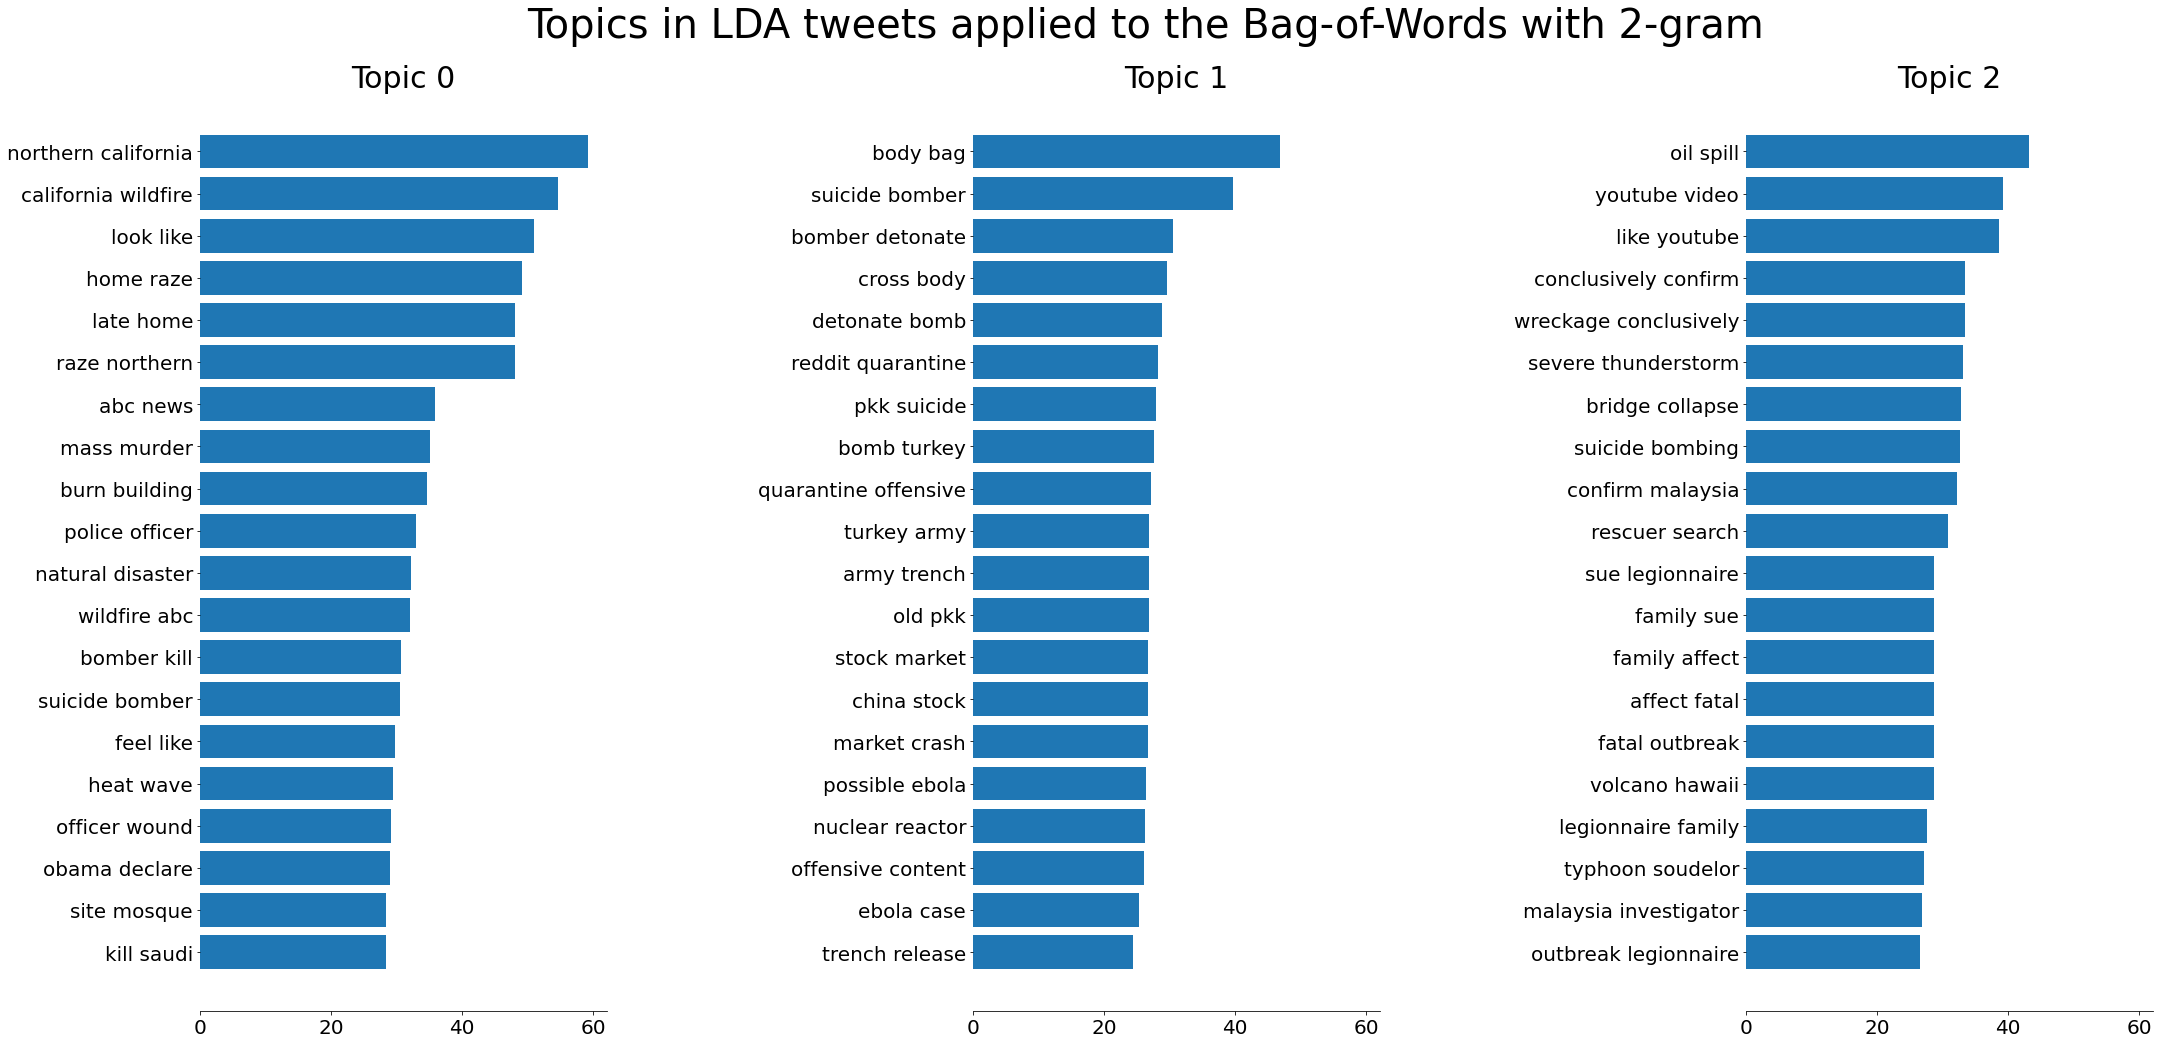

In [47]:
words_bow_2g = bow_model.get_feature_names()
lda_2g = lda_model.fit(bow_2g)
lda_topic_results_2g = lda_model.transform(bow_2g)
plot_top_words(lda_2g, words_bow_2g, n_top_words, 'Topics in LDA tweets applied to the Bag-of-Words with 2-gram')

### 3-gram

In [48]:
# Tokenization into 3-gram and vectorization 
np.random.seed(0)
# Dropped tokens that appeared in less than 2 sentences 
bow_model = CountVectorizer(analyzer='word', 
                             ngram_range=(3,3), 
                             min_df=2,                         # minimum required occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000)                # max number of unique words.                             
bow_model.fit(df_new['text_cleaned'])
bow_3g = bow_model.transform(df_new['text_cleaned'])

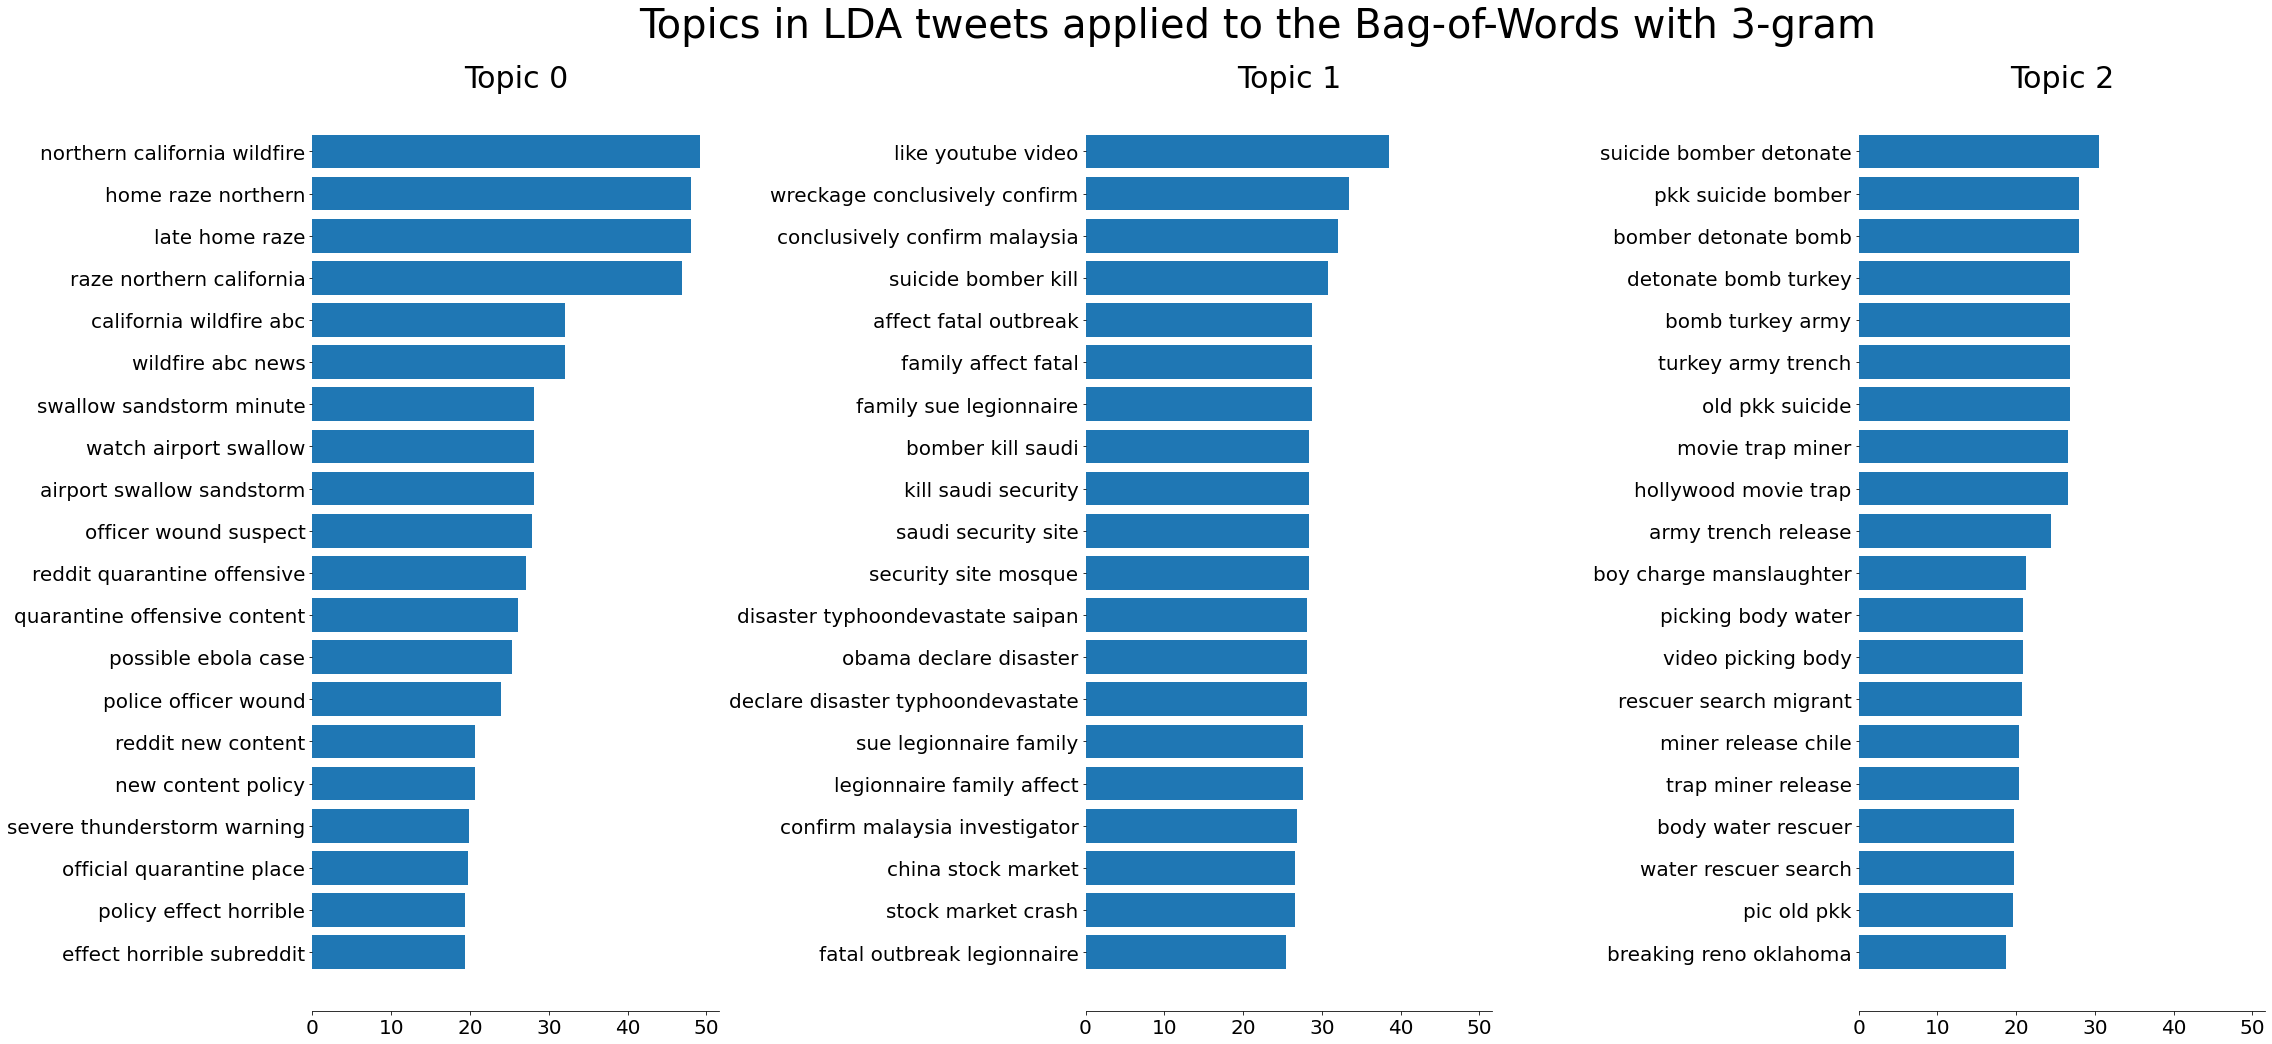

In [49]:
words_bow_3g = bow_model.get_feature_names()
lda_3g = lda_model.fit(bow_3g)
lda_topic_results_3g = lda_model.transform(bow_3g)
plot_top_words(lda_3g, words_bow_3g, n_top_words, 'Topics in LDA tweets applied to the Bag-of-Words with 3-gram')

In [50]:
# train set with assigned topic for each sentence by n-gram and score
df_new['topic_1_gram'] = lda_topic_results_1g.argmax(axis = 1)
df_new['score_1_gram'] = np.amax(lda_topic_results_1g.tolist(),1)
df_new['topic_2_gram'] = lda_topic_results_2g.argmax(axis = 1)
df_new['score_2_gram'] = np.amax(lda_topic_results_2g.tolist(),1)
df_new['topic_3_gram'] = lda_topic_results_3g.argmax(axis = 1)
df_new['score_3_gram'] = np.amax(lda_topic_results_3g.tolist(),1)
df_new.head(10)

,id,keyword,location,text,target,lang,text_cleaned,topic_1_gram,score_1_gram,topic_2_gram,score_2_gram,topic_3_gram,score_3_gram
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,en,deed reason earthquake allah forgive,2,0.886884,0,0.333333,0,0.333333
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,en,forest near la ronge sask canada,0,0.817527,0,0.333333,0,0.333333
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,en,resident ask shelter place notify officer evac...,0,0.603144,0,0.333333,0,0.333333
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,en,people receive wildfire evacuation order calif...,2,0.903053,1,0.666467,0,0.333333
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,en,got send photo ruby alaska smoke wildfire pour...,1,0.592252,0,0.333333,0,0.333333
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,en,rockyfire update california hwy closed directi...,2,0.932638,0,0.664967,0,0.333333
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,en,flood disaster heavy rain cause flash flooding...,2,0.849608,2,0.833069,0,0.333333
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,en,I m hill wood,0,0.769676,0,0.333333,0,0.333333
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,en,there s emergency evacuation happen building s...,2,0.887432,2,0.776786,0,0.333333
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,en,I m afraid tornado come area,2,0.531100,0,0.333333,0,0.333333


### Word Embedding

In [51]:
def tokenize(text):
    text = str(text).replace("\n", " ")
    tokens = word_tokenize(text)
    return tokens

In [52]:
data = df_new['text_cleaned'].apply(tokenize)
def vocabulary(text):        
    corpus = []
    for word in text:
        corpus.append(word)
    return corpus

In [53]:
corpus = vocabulary(data)

In [54]:
def similar(model, word):
    return model.wv.most_similar(word) 

def embedding(model, word):
    return model.wv[word]

def similarity(model, word1, word2):
    return model.wv.similarity(word1, word2)

### CBOW model

![](https://media.geeksforgeeks.org/wp-content/uploads/cbow-1.png)

In [55]:
# Create CBOW model
model1 = Word2Vec(corpus, min_count = 1, window = 5)

In [56]:
print(model1)

Word2Vec(vocab=14799, vector_size=100, alpha=0.025)


In [57]:
similar(model1, 'wildfire')

[('home', 0.9865533113479614),
 ('california', 0.9847142100334167),
 ('late', 0.9846445322036743),
 ('news', 0.9835512042045593),
 ('police', 0.9819474220275879),
 ('man', 0.9817566871643066),
 ('come', 0.9813889265060425),
 ('amp', 0.981350839138031),
 ('emergency', 0.9812728762626648),
 ('rt', 0.981052815914154)]

In [58]:
embedding(model1, 'wildfire')

array([-0.0583482 ,  0.05796097,  0.03426416, -0.00592028,  0.00852391,
       -0.10175705, -0.00086446,  0.14553608, -0.05313656, -0.03492072,
       -0.04071965, -0.10598782, -0.03991127,  0.0037888 ,  0.02143267,
       -0.0363395 , -0.02955247, -0.10715866,  0.02839666, -0.14676094,
        0.01607858,  0.05317243,  0.05073941, -0.0429176 , -0.00943622,
        0.03764036, -0.07987895, -0.08346124, -0.0416766 ,  0.03119909,
        0.04772996,  0.03840136,  0.03493245, -0.05755643, -0.00970739,
        0.08625988,  0.00407669, -0.01363793, -0.0471837 , -0.12123238,
        0.05557646, -0.06530095, -0.04592042,  0.00775568,  0.05991337,
       -0.05763759, -0.05166172, -0.017017  ,  0.04424195,  0.04808197,
        0.00997267, -0.06936783, -0.06446403,  0.0365411 , -0.03435877,
        0.04559166,  0.04266481, -0.00490351, -0.07929803,  0.03617224,
        0.02539956,  0.0383447 , -0.03355975,  0.02701116, -0.07390254,
        0.06544235,  0.00269664,  0.00758491, -0.07040416,  0.07

In [59]:
similarity(model1, 'wildfire', "california")

0.9847142

### Skip Gram model

![](https://media.geeksforgeeks.org/wp-content/uploads/skip_gram.png)

In [60]:
# Create Skip Gram model
model2 = Word2Vec(corpus, min_count = 1,window = 5, sg = 1)

In [61]:
print(model2)

Word2Vec(vocab=14799, vector_size=100, alpha=0.025)


In [62]:
similar(model2, 'wildfire')

[('california', 0.993296205997467),
 ('raze', 0.9928207397460938),
 ('home', 0.9880279898643494),
 ('late', 0.9858505725860596),
 ('abc', 0.9790722131729126),
 ('northern', 0.9768778681755066),
 ('fire', 0.9738628268241882),
 ('news', 0.9680289030075073),
 ('parole', 0.954095721244812),
 ('catch', 0.9517317414283752)]

In [63]:
embedding(model2, 'wildfire')

array([-0.26024926,  0.15233842,  0.09784354, -0.0876351 , -0.10162074,
       -0.2744654 , -0.20882937,  0.6151672 , -0.29287228, -0.13433471,
       -0.20705928, -0.31967005, -0.31793627, -0.2344982 , -0.01932346,
       -0.05222828, -0.25150335, -0.63457596,  0.311056  , -0.59908867,
        0.04134774,  0.451166  ,  0.5011864 , -0.16722023, -0.01581858,
        0.16648844, -0.42518362, -0.49821556, -0.19659077,  0.14754853,
        0.11869355,  0.24167293,  0.3443862 , -0.2843539 ,  0.03613755,
        0.33832008, -0.04213526,  0.03697721, -0.11101645, -0.4730704 ,
        0.43470117, -0.11665467, -0.26897585,  0.11162768,  0.20602946,
       -0.3457005 , -0.139284  , -0.21108167,  0.30496305,  0.2279898 ,
       -0.01183805, -0.33538195, -0.35300612,  0.29203382, -0.1063115 ,
        0.20953834,  0.06317057,  0.00491823, -0.32880864,  0.3534993 ,
        0.26368377,  0.2005606 , -0.18427452,  0.15012367, -0.36591458,
        0.1669535 ,  0.04291821, -0.10848501, -0.29505232,  0.45

In [64]:
similarity(model2, 'wildfire', "california")

0.9932962